In [1]:
import os
import datetime

import IPython
import IPython.display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


limit1GPU=True
if(limit1GPU):
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("WARNING: Limited use of GPU to a single GPU with:")
    print('os.environ["CUDA_VISIBLE_DEVICES"] ='+str(os.environ["CUDA_VISIBLE_DEVICES"] ))

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

os.environ["CUDA_VISIBLE_DEVICES"] =1


In [2]:
df = pd.read_csv('./ETTh1.csv')
date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d %H:%M:%S')
df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


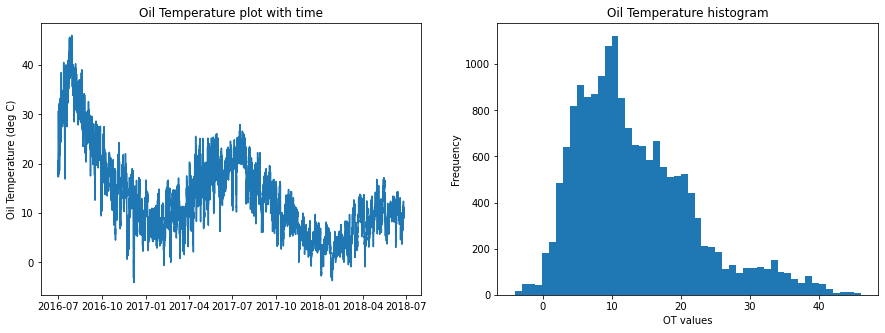

In [3]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

plot_col = df[['OT']]
plot_col.index = date_time
axs[0].plot(plot_col.index, plot_col)
axs[1].set_xlabel('Date')
axs[0].set_ylabel('Oil Temperature (deg C)')
axs[0].set_title('Oil Temperature plot with time')

axs[1].hist(df['OT'], bins=50)
axs[1].set_xlabel('OT values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Oil Temperature histogram')
plt.show()

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HUFL,17420.0,7.375141,7.067744,-22.705999,5.827,8.774,11.788,23.643999
HULL,17420.0,2.242242,2.042342,-4.756000,0.737,2.210,3.684,10.114000
MUFL,17420.0,4.300239,6.826978,-25.087999,3.296,5.970,8.635,17.341000
MULL,17420.0,0.881568,1.809293,-5.934000,-0.284,0.959,2.203,7.747000
LUFL,17420.0,3.066062,1.164506,-1.188000,2.315,2.833,3.625,8.498000
LULL,17420.0,0.856932,0.599552,-1.371000,0.670,0.975,1.218,3.046000
OT,17420.0,13.324672,8.566946,-4.080000,6.964,11.396,18.079,46.007000


In [5]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean)/train_std
val_df = (val_df - train_mean)/train_std
test_df = (test_df - train_mean)/train_std

In [7]:
class WindowGenerator():

    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        
        self.train_data = train_df
        self.val_data = val_df
        self.test_data = test_df

        self.label_columns = label_columns

        if label_columns is not None:
            self.label_columns_indices = {name:i for i, name in enumerate(label_columns)}
        
        self.column_indices = {name:i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, data):
        inputs = data[:, self.input_slice,:]
        labels = data[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :,self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, inputs, labels, model=None, plot_col='OT', max_subplots=3):
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model.predict(inputs)
                plt.scatter(self.label_indices, predictions[n,label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    
    @property
    def train(self):
        return self.make_dataset(self.train_data)
    
    @property
    def val(self):
        return self.make_dataset(self.val_data)
    
    @property
    def test(self):
        return self.make_dataset(self.test_data)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

##### Feed Forward model

In [8]:
simple_window = WindowGenerator(input_width=10,label_width=1, shift=1, label_columns=['OT'])

simple_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['OT']

In [9]:
for input, label in simple_window.train.take(1):
    input_x = input
    label_y = label
    print('Input data shape:', input.shape)
    print('Label shape:', label.shape)

Input data shape: (32, 10, 7)
Label shape: (32, 1, 1)


In [10]:
simple_model =  keras.Sequential(
    [
        keras.Input(shape=(10, 7)),
        layers.Dense(units=64, activation='relu', name='first_layer'),
        layers.Dense(units=64, activation='relu', name='second_layer'),
        layers.Flatten(),
        layers.Dense(units=1, activation='relu', name='third_layer')
    ]
)

simple_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_layer (Dense)          (None, 10, 64)            512       
_________________________________________________________________
second_layer (Dense)         (None, 10, 64)            4160      
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
third_layer (Dense)          (None, 1)                 641       
Total params: 5,313
Trainable params: 5,313
Non-trainable params: 0
_________________________________________________________________


In [11]:
MAX_EPOCHS = 10

def compile_and_fit(model, window):

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
  return history

In [12]:
h = compile_and_fit(simple_model, simple_window)

Epoch 1/10
381/381 [==============================] - 2s 3ms/step - loss: 1.0058 - mean_absolute_error: 0.7869 - val_loss: 2.0676 - val_mean_absolute_error: 1.3934
Epoch 2/10
381/381 [==============================] - 1s 2ms/step - loss: 0.9949 - mean_absolute_error: 0.7786 - val_loss: 2.0653 - val_mean_absolute_error: 1.3927
Epoch 3/10
381/381 [==============================] - 1s 2ms/step - loss: 0.9142 - mean_absolute_error: 0.7256 - val_loss: 2.0536 - val_mean_absolute_error: 1.3890
Epoch 4/10
381/381 [==============================] - 1s 2ms/step - loss: 0.4645 - mean_absolute_error: 0.5246 - val_loss: 2.0534 - val_mean_absolute_error: 1.3890
Epoch 5/10
381/381 [==============================] - 1s 2ms/step - loss: 0.4113 - mean_absolute_error: 0.4816 - val_loss: 2.0534 - val_mean_absolute_error: 1.3890
Epoch 6/10
381/381 [==============================] - 1s 2ms/step - loss: 0.4050 - mean_absolute_error: 0.4717 - val_loss: 2.0534 - val_mean_absolute_error: 1.3890
Epoch 7/10
381/3

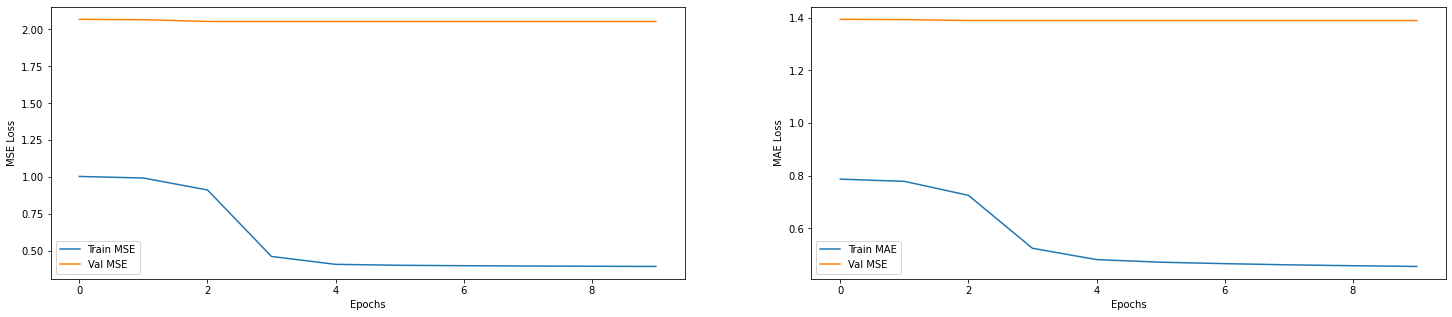

In [13]:
fig, axs = plt.subplots(1,2, figsize=(25,5))
metrics = list(h.history.keys())

axs[0].plot(h.history['loss'], label='Train MSE')
axs[0].plot(h.history['val_loss'], label='Val MSE')
axs[0].set_ylabel('MSE Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()

axs[1].plot(h.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(h.history['val_mean_absolute_error'], label='Val MSE')
axs[1].set_ylabel('MAE Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()
plt.show()

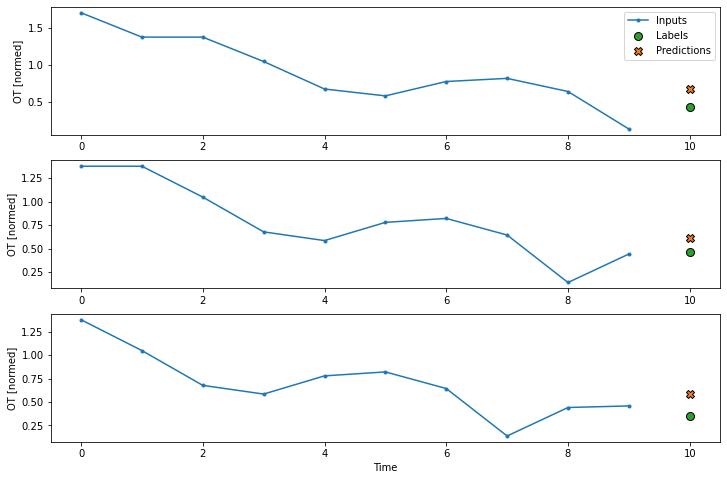

In [14]:
simple_window.plot(input_x, label_y, simple_model)

##### Convolution Model

In [15]:
cnn_window = WindowGenerator(input_width=10, label_width=1, shift=1, label_columns=['OT'])

cnn_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['OT']

In [16]:
for input, label in cnn_window.train.take(1):
    input_x = input
    label_y = label
    print('Input Shape:', input.shape)
    print('Output Shape:', label.shape)

Input Shape: (32, 10, 7)
Output Shape: (32, 1, 1)


In [17]:
# kernel size is same as input because we want to predict the label accounting for all the input. If kernel size is smaller than input then you would need to add more layers so that the entire input is covered to predict the label
cnn_model = keras.Sequential(
    [
        keras.Input(shape=(10,7)),
        layers.Conv1D(filters=32, kernel_size=(10,),activation='relu'),
        layers.Dense(units=32, activation='relu'),
        layers.Dense(units=1)
    ]
)

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 32)             2272      
_________________________________________________________________
dense (Dense)                (None, 1, 32)             1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              33        
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________


In [18]:
h_cnn = compile_and_fit(cnn_model, cnn_window)

Epoch 1/10
381/381 [==============================] - 3s 3ms/step - loss: 0.9344 - mean_absolute_error: 0.6548 - val_loss: 0.6234 - val_mean_absolute_error: 0.7394
Epoch 2/10
381/381 [==============================] - 1s 3ms/step - loss: 0.5154 - mean_absolute_error: 0.4556 - val_loss: 0.2443 - val_mean_absolute_error: 0.4261
Epoch 3/10
381/381 [==============================] - 1s 3ms/step - loss: 0.2475 - mean_absolute_error: 0.3182 - val_loss: 0.1014 - val_mean_absolute_error: 0.2529
Epoch 4/10
381/381 [==============================] - 1s 3ms/step - loss: 0.1406 - mean_absolute_error: 0.2551 - val_loss: 0.0632 - val_mean_absolute_error: 0.1957
Epoch 5/10
381/381 [==============================] - 1s 3ms/step - loss: 0.0964 - mean_absolute_error: 0.2189 - val_loss: 0.0499 - val_mean_absolute_error: 0.1729
Epoch 6/10
381/381 [==============================] - 1s 3ms/step - loss: 0.0716 - mean_absolute_error: 0.1945 - val_loss: 0.0431 - val_mean_absolute_error: 0.1611
Epoch 7/10
381/3

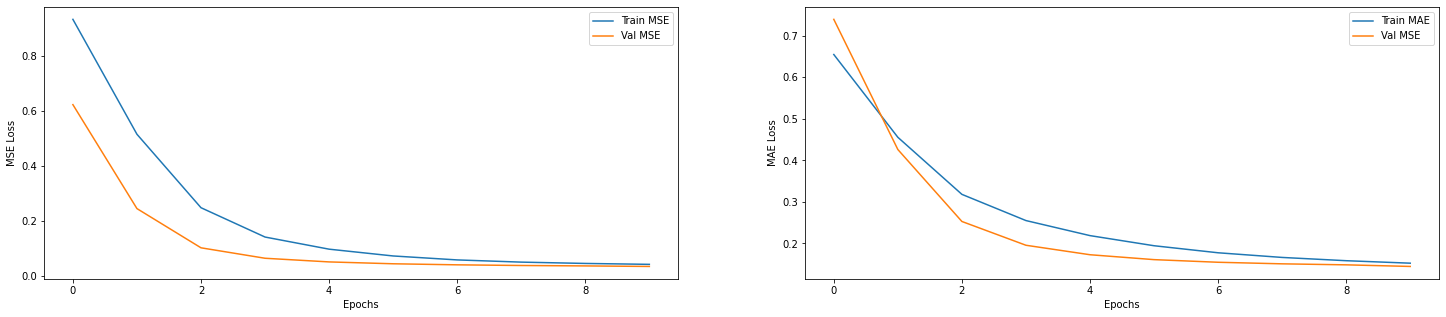

In [19]:
fig, axs = plt.subplots(1,2, figsize=(25,5))
metrics = list(h.history.keys())

axs[0].plot(h_cnn.history['loss'], label='Train MSE')
axs[0].plot(h_cnn.history['val_loss'], label='Val MSE')
axs[0].set_ylabel('MSE Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()

axs[1].plot(h_cnn.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(h_cnn.history['val_mean_absolute_error'], label='Val MSE')
axs[1].set_ylabel('MAE Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()
plt.show()

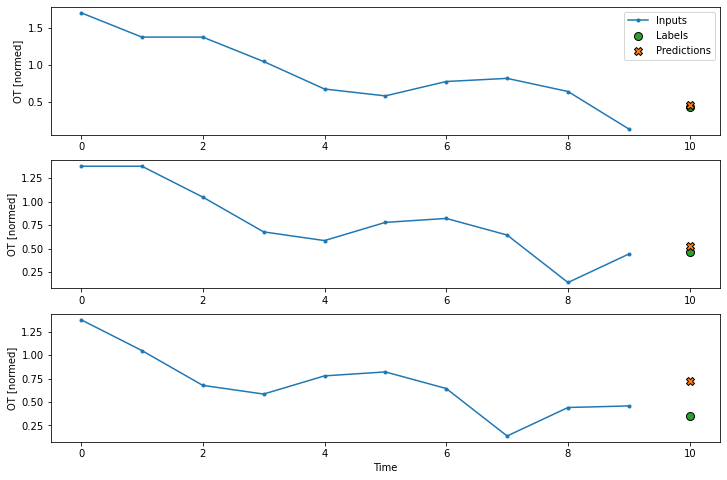

In [20]:
cnn_window.plot(input_x, label_y, cnn_model)

#### Recurrent Model

In [21]:
rnn_window = WindowGenerator(input_width=10, label_width=1, shift=1, label_columns=['OT'])

rnn_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['OT']

In [22]:
for input, label in rnn_window.train.take(1):
    input_x = input
    label_y = label
    print('Input Shape:', input.shape)
    print('Output Shape:', label.shape)

Input Shape: (32, 10, 7)
Output Shape: (32, 1, 1)


In [23]:
rnn_model = keras.Sequential(
    [
        keras.Input(shape=(10,7)),
        layers.LSTM(16, activation='relu',recurrent_activation='hard_sigmoid', return_sequences=True),
        layers.LSTM(16, activation='relu',recurrent_activation='hard_sigmoid'),
        layers.Dense(1)
    ]
)

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 16)            1536      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 3,665
Trainable params: 3,665
Non-trainable params: 0
_________________________________________________________________


In [24]:
h_rnn = compile_and_fit(rnn_model, rnn_window)

Epoch 1/10
381/381 [==============================] - 29s 70ms/step - loss: 0.9593 - mean_absolute_error: 0.7708 - val_loss: 2.1485 - val_mean_absolute_error: 1.4279
Epoch 2/10
381/381 [==============================] - 28s 72ms/step - loss: 0.8022 - mean_absolute_error: 0.6930 - val_loss: 2.0546 - val_mean_absolute_error: 1.3960
Epoch 3/10
381/381 [==============================] - 28s 74ms/step - loss: 0.5966 - mean_absolute_error: 0.5758 - val_loss: 1.8844 - val_mean_absolute_error: 1.3346
Epoch 4/10
381/381 [==============================] - 27s 72ms/step - loss: 0.4365 - mean_absolute_error: 0.4955 - val_loss: 1.7109 - val_mean_absolute_error: 1.2698
Epoch 5/10
381/381 [==============================] - 27s 72ms/step - loss: 0.3663 - mean_absolute_error: 0.4608 - val_loss: 1.4732 - val_mean_absolute_error: 1.1754
Epoch 6/10
381/381 [==============================] - 27s 72ms/step - loss: 0.2897 - mean_absolute_error: 0.4131 - val_loss: 1.0626 - val_mean_absolute_error: 0.9927
Epoc

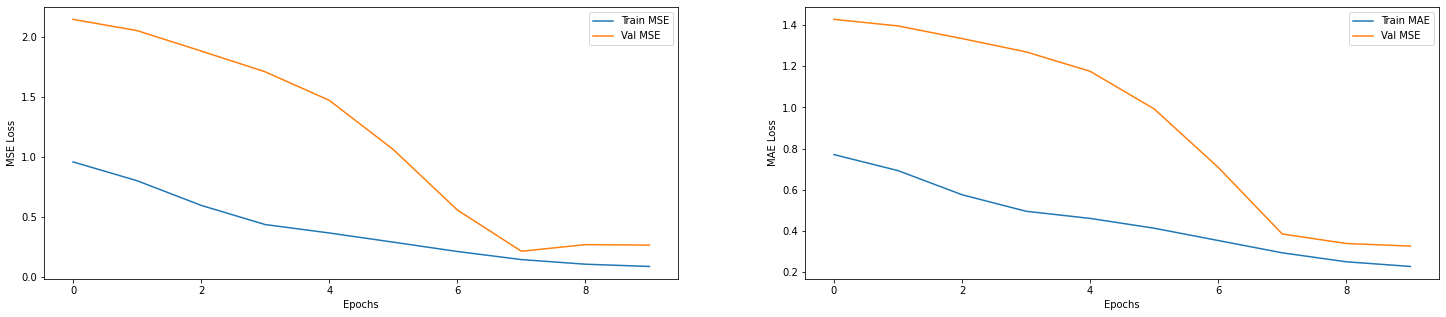

In [25]:
fig, axs = plt.subplots(1,2, figsize=(25,5))
metrics = list(h.history.keys())

axs[0].plot(h_rnn.history['loss'], label='Train MSE')
axs[0].plot(h_rnn.history['val_loss'], label='Val MSE')
axs[0].set_ylabel('MSE Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()

axs[1].plot(h_rnn.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(h_rnn.history['val_mean_absolute_error'], label='Val MSE')
axs[1].set_ylabel('MAE Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()
plt.show()

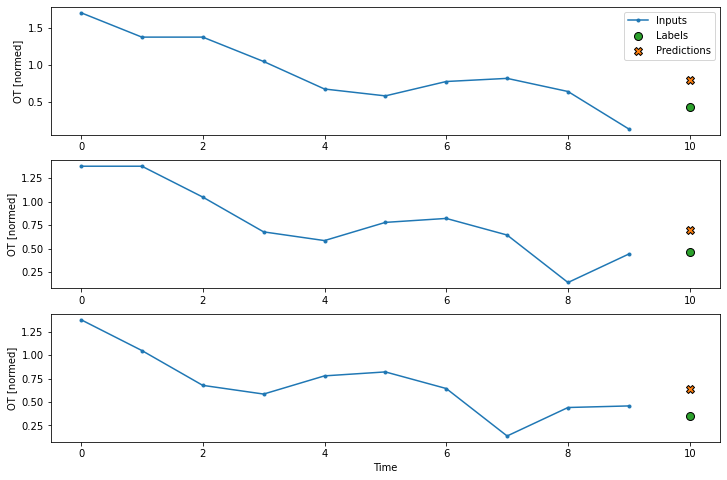

In [26]:
rnn_window.plot(input_x, label_y, rnn_model)